# YOLOv5

### Data Preparation

In [2]:
import os
import xml.etree.ElementTree as ET
from glob import glob

def convert_bbox(size, box):
    if size[0] == 0 or size[1] == 0:
        raise ValueError(f"Invalid image size: {size}")
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def convert_annotation(xml_file, classes):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    if w == 0 or h == 0:
        print(f"Warning: Invalid image size in {xml_file}. Skipping this file.")
        return

    out_file = xml_file.replace('Annotations', 'labels').replace('.xml', '.txt')
    out_dir = os.path.dirname(out_file)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    with open(out_file, 'w') as out:
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult) == 1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                 float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
            try:
                bb = convert_bbox((w, h), b)
                out.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")
            except ValueError as e:
                print(f"Error in file {xml_file}: {str(e)}")

def process_dataset(dataset_path):
    classes = []
    for xml_file in glob(os.path.join(dataset_path, '**/Annotations/*.xml'), recursive=True):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                classes.append(cls)
    
    classes.sort()
    print(f"Classes found: {classes}")

    for xml_file in glob(os.path.join(dataset_path, '**/Annotations/*.xml'), recursive=True):
        convert_annotation(xml_file, classes)

    # We create classes.txt file
    with open(os.path.join(dataset_path, 'classes.txt'), 'w') as f:
        for cls in classes:
            f.write(f"{cls}\n")

    print("Conversion completed.")


dataset_path = '/teamspace/studios/this_studio/dataset'
process_dataset(dataset_path)

Classes found: ['person', 'person-like']
Conversion completed.


In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob

def get_classes(dataset_path):
    classes = set()
    for xml_file in glob(os.path.join(dataset_path, '**/Annotations/*.xml'), recursive=True):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.iter('object'):
            cls = obj.find('name').text
            classes.add(cls)
    
    return sorted(list(classes))


dataset_path = '/teamspace/studios/this_studio/dataset'
classes = get_classes(dataset_path)

print(f"Number of classes: {len(classes)}")
print("Classes:")
for i, cls in enumerate(classes):
    print(f"{i}: {cls}")

Number of classes: 2
Classes:
0: person
1: person-like


In [4]:
# Dowloding yolo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...



In [5]:
cd yolov5/

/teamspace/studios/this_studio/yolov5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
!pip install -r requirements.txt

### Training Model

In [17]:
!python train.py --img 640 --batch 32 --epochs 100 --data data/pedestrian.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=data/pedestrian.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_p

### Validation

In [18]:
!python val.py --weights runs/train/exp12/weights/best.pt --data data/pedestrian.yaml --img 640 --batch 32

val: data=data/pedestrian.yaml, weights=['runs/train/exp12/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /teamspace/studios/this_studio/dataset/labels/Val/JPEGImages.cache
                 Class     Images  Instances          P          R      mAP50   
                   all        160        333      0.853      0.879      0.898      0.637
                person        160        203      0.807      0.857      0.874      0.601
           person-like        160        130      0.898        0.9      0.921      0.673
Speed: 0.3ms pre-process, 4

In [2]:
cd yolov5/

/teamspace/studios/this_studio/yolov5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!python val.py --weights runs/train/exp12/weights/best.pt --data data/pedestrian.yaml --img 640 --task test --name cm --conf-thres 0.001

val: data=data/pedestrian.yaml, weights=['runs/train/exp12/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=cm, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /teamspace/studios/this_studio/dataset/labels/Test/JPEGImages.cac
                 Class     Images  Instances          P          R      mAP50   
                   all        235        592      0.875      0.811      0.893      0.606
                person        235        316       0.87      0.826      0.888      0.558
           person-like        235        276       0.88      0.797      0.899      0.654
Speed: 0.4ms pre-process, 6.

### Detection

In [4]:
!python detect.py --weights runs/train/exp12/weights/best.pt --source /teamspace/studios/this_studio/test_images/5-people-business.jpg --img 640

detect: weights=['runs/train/exp12/weights/best.pt'], source=/teamspace/studios/this_studio/test_images/5-people-business.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /teamspace/studios/this_studio/test_images/5-people-business.jpg: 448x640 5 persons, 1 person-like, 52.6ms
Speed: 0.8ms pre-process, 52.6ms inference, 506.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


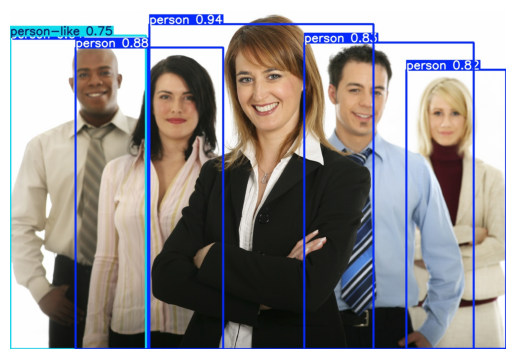

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image with detections
img_path = 'runs/detect/exp4/5-people-business.jpg'
img = Image.open(img_path)

# Displaying the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [9]:
!python detect.py --weights runs/train/exp12/weights/best.pt --source /teamspace/studios/this_studio/test_images/group-super-mario-costumes.jpg --img 640

detect: weights=['runs/train/exp12/weights/best.pt'], source=/teamspace/studios/this_studio/test_images/group-super-mario-costumes.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /teamspace/studios/this_studio/test_images/group-super-mario-costumes.jpg: 320x640 5 person-likes, 46.2ms
Speed: 0.4ms pre-process, 46.2ms inference, 531.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp6


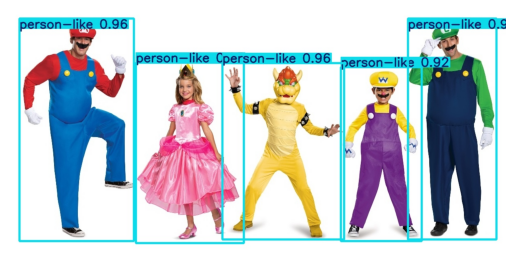

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# Loading the image with its detections
img_path = 'runs/detect/exp6/group-super-mario-costumes.jpg'
img = Image.open(img_path)

# Displaying the image
plt.imshow(img)
plt.axis('off')  
plt.show()


In [11]:
!python detect.py --weights runs/train/exp12/weights/best.pt --source /teamspace/studios/this_studio/test_images/young-professionals.jpg --img 640

detect: weights=['runs/train/exp12/weights/best.pt'], source=/teamspace/studios/this_studio/test_images/young-professionals.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /teamspace/studios/this_studio/test_images/young-professionals.jpg: 448x640 11 persons, 46.4ms
Speed: 0.6ms pre-process, 46.4ms inference, 520.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp7


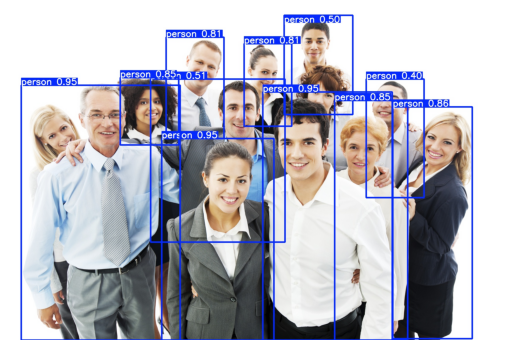

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

# Loading the image with detections
img_path = 'runs/detect/exp7/young-professionals.jpg'
img = Image.open(img_path)

# Displaying the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [27]:
!python detect.py --weights runs/train/exp12/weights/best.pt --img 640 --conf 0.25 --source "/teamspace/studios/this_studio/dataset/images/Test/JPEGImages/image (5).jpg"

detect: weights=['runs/train/exp12/weights/best.pt'], source=/teamspace/studios/this_studio/dataset/images/Test/JPEGImages/image (5).jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /teamspace/studios/this_studio/dataset/images/Test/JPEGImages/image (5).jpg: 640x640 1 person, 4.7ms
Speed: 0.3ms pre-process, 4.7ms inference, 362.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


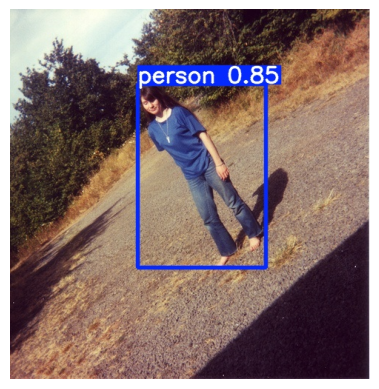

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

# Loading the image with detections
img_path = 'runs/detect/exp3/image (5).jpg'
img = Image.open(img_path)

# Displaying the image
plt.imshow(img)
plt.axis('off')  
plt.show()


In [8]:
!tensorboard --logdir runs/train

2024-06-22 09:01:39.931805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 09:01:39.986361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 09:01:40.815803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-22 09:01:41.829959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://g

In [2]:
!python val.py --weights runs/train/exp12/weights/best.pt --data data/pedestrian.yaml --img 640 --task test --name pr-curve

python: can't open file '/teamspace/studios/this_studio/val.py': [Errno 2] No such file or directory


In [2]:
!python val.py --weights runs/train/exp12/weights/best.pt --data data/pedestrian.yaml --task test --name confusion_matrix --conf-thres 0.001


val: data=data/pedestrian.yaml, weights=['runs/train/exp12/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=confusion_matrix, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /teamspace/studios/this_studio/dataset/labels/Test/JPEGImages.cac
                 Class     Images  Instances          P          R      mAP50   
                   all        235        592      0.875      0.811      0.893      0.606
                person        235        316       0.87      0.826      0.888      0.558
           person-like        235        276       0.88      0.797      0.899      0.654
Speed: 0.4ms p

In [3]:
!python val.py --weights runs/train/exp12/weights/best.pt --data data/pedestrian.yaml --task test --name pr_curve --conf-thres 0.001

val: data=data/pedestrian.yaml, weights=['runs/train/exp12/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=pr_curve, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /teamspace/studios/this_studio/dataset/labels/Test/JPEGImages.cac
                 Class     Images  Instances          P          R      mAP50   
                   all        235        592      0.875      0.811      0.893      0.606
                person        235        316       0.87      0.826      0.888      0.558
           person-like        235        276       0.88      0.797      0.899      0.654
Speed: 0.3ms pre-proce

# Faster R CNN

In [1]:
import os
import xml.etree.ElementTree as ET
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from torchvision.ops import box_iou
from collections import defaultdict
from torchvision.ops import box_iou, nms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Data Preparation

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        ann_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        
        img = Image.open(img_path).convert("RGB")
        img = F.to_tensor(img)  # Convert image to tensor
        
        target = self.parse_voc_xml(ET.parse(ann_path).getroot())
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def parse_voc_xml(self, node):
        target = {}
        boxes = []
        labels = []
        
        for obj in node.findall('object'):
            label = 1 if obj.find('name').text == 'person' else 2  # 1 for person, 2 for person-like
            bndbox = obj.find('bndbox')
            box = [
                float(bndbox.find('xmin').text),
                float(bndbox.find('ymin').text),
                float(bndbox.find('xmax').text),
                float(bndbox.find('ymax').text)
            ]
            boxes.append(box)
            labels.append(label)
        
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
        return target

### Model Setup

In [3]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=None)  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


### Training

In [4]:
def train(model, data_loader, optimizer, device, num_epochs):
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            total_loss += losses.item()
        
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")



In [5]:
def calculate_mAP(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    all_detections = []
    all_ground_truths = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                detections = {
                    'boxes': output['boxes'].cpu(),
                    'scores': output['scores'].cpu(),
                    'labels': output['labels'].cpu()
                }
                all_detections.append(detections)
                all_ground_truths.append({k: v.cpu() for k, v in target.items()})
    
    ap_per_class = defaultdict(list)
    
    for detections, ground_truths in zip(all_detections, all_ground_truths):
        for class_id in torch.unique(ground_truths['labels']):
            true_positives = torch.zeros(len(detections['boxes']))
            false_positives = torch.zeros(len(detections['boxes']))
            
            gt_masks = ground_truths['labels'] == class_id
            gt_boxes = ground_truths['boxes'][gt_masks]
            
            if len(gt_boxes) == 0:
                continue
            
            det_masks = detections['labels'] == class_id
            det_boxes = detections['boxes'][det_masks]
            det_scores = detections['scores'][det_masks]
            
            if len(det_boxes) == 0:
                continue
            
            ious = box_iou(det_boxes, gt_boxes)
            max_ious, max_indices = ious.max(dim=1)
            
            for i, iou in enumerate(max_ious):
                if iou >= iou_threshold:
                    true_positives[i] = 1
                else:
                    false_positives[i] = 1
            
            sorted_indices = torch.argsort(det_scores, descending=True)
            true_positives = true_positives[sorted_indices]
            false_positives = false_positives[sorted_indices]
            
            cum_true_positives = torch.cumsum(true_positives, dim=0)
            cum_false_positives = torch.cumsum(false_positives, dim=0)
            
            precision = cum_true_positives / (cum_true_positives + cum_false_positives + 1e-10)
            recall = cum_true_positives / len(gt_boxes)
            
            ap = torch.trapz(precision, recall)
            ap_per_class[class_id.item()].append(ap.item())
    
    mAP = sum(sum(aps) / len(aps) for aps in ap_per_class.values()) / len(ap_per_class)
    return mAP

### Evaluation


In [6]:
def evaluate(model, data_loader, device):
    model.eval()
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            
            outputs = model(images)
            
            img = images[0].cpu()
            output = outputs[0]
            
            # Getting predictions with high confidence
            keep = output['scores'] > 0.7
            boxes = output['boxes'][keep]
            labels = output['labels'][keep]
            
            # Drawing bounding boxes
            img_with_boxes = draw_boxes(img, boxes, labels)
            
            plt.figure(figsize=(12, 8))
            plt.imshow(img_with_boxes.permute(1, 2, 0))
            plt.axis('off')
            plt.show()
            break  # Showing one image 

def draw_boxes(image, boxes, labels):
    img = image.clone()
    for box, label in zip(boxes, labels):
        color = torch.tensor([1.0, 0.0, 0.0]) if label == 1 else torch.tensor([0.0, 1.0, 0.0])  # Red for person, Green for person-like
        x1, y1, x2, y2 = box.int()
        
        # WE ensure coordinates are within image boundaries
        x1 = max(0, min(x1, img.shape[2] - 1))
        x2 = max(0, min(x2, img.shape[2] - 1))
        y1 = max(0, min(y1, img.shape[1] - 1))
        y2 = max(0, min(y2, img.shape[1] - 1))
        
        # Drawing horizontal lines
        img[:, y1, x1:x2] = color.unsqueeze(1).expand(3, x2 - x1)
        img[:, y2, x1:x2] = color.unsqueeze(1).expand(3, x2 - x1)
        
        # Drawing vertical lines
        img[:, y1:y2, x1] = color.unsqueeze(1).expand(3, y2 - y1)
        img[:, y1:y2, x2] = color.unsqueeze(1).expand(3, y2 - y1)
    
    return img

In [8]:
# Setting up datasets and dataloaders
print("Setting up datasets...")
train_dataset = CustomDataset("/teamspace/studios/this_studio/dataset_f_r_cnn/Train/Train")
val_dataset = CustomDataset("/teamspace/studios/this_studio/dataset_f_r_cnn/Val/Val")
test_dataset = CustomDataset("/teamspace/studios/this_studio/dataset_f_r_cnn/Test/Test")

print(f"Dataset sizes: Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

def collate_fn(batch):
    return tuple(zip(*batch))

print("Creating data loaders...")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=32, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=8, pin_memory=True)

# Setting up model and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

print("Initializing model...")
model = get_model(num_classes=3)  # 3 classes: background, person, person-like
print(f"Model architecture:\n{model}")

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
print(f"Optimizer: {optimizer}")

# Training the model
num_epochs = 100
print(f"Starting training for {num_epochs} epochs...")

accumulation_steps = 2  
scaler = GradScaler()

def train_with_debug(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, accumulation_steps, scaler):
    model.to(device)
    best_mAP = 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        start_time = time.time()
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        optimizer.zero_grad()  # Move this outside the loop
        
        for i, (images, targets) in enumerate(progress_bar):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                losses = losses / accumulation_steps
            
            scaler.scale(losses).backward()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            epoch_loss += losses.item() * accumulation_steps
            
            if i % 10 == 0:
                progress_bar.set_postfix({'batch_loss': losses.item() * accumulation_steps})
        
        scheduler.step()
        
        avg_loss = epoch_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")
        print(f"Current learning rate: {scheduler.get_last_lr()[0]:.6f}")
        
        val_loss, val_mAP = validate(model, val_loader, device)
        
        if val_mAP > best_mAP:
            best_mAP = val_mAP
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best model saved with mAP: {best_mAP:.4f}")

    print(f"Training completed. Best mAP: {best_mAP:.4f}")


def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            model.train()
            loss_dict = model(images, targets)
            model.eval()
            
            if isinstance(loss_dict, list):
                total_loss += sum(sum(d.values()) for d in loss_dict).item()
            else:
                total_loss += sum(loss for loss in loss_dict.values()).item()
    
    avg_loss = total_loss / len(data_loader)
    mAP = calculate_mAP(model, data_loader, device)
    print(f"Validation Loss: {avg_loss:.4f}, mAP: {mAP:.4f}")
    return avg_loss, mAP

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_with_debug(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, accumulation_steps, scaler)


Setting up datasets...
Dataset sizes: Train: 944, Val: 160, Test: 235
Creating data loaders...
Using device: cuda
Initializing model...


Model architecture:
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
   

Epoch 1/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.207]

Epoch 1/100, Avg Loss: 0.3595, Time: 91.36s
Current learning rate: 0.005000


Validation Loss: 0.2314, mAP: 0.5183
New best model saved with mAP: 0.5183


Epoch 2/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.18] 

Epoch 2/100, Avg Loss: 0.1973, Time: 91.79s
Current learning rate: 0.005000


Validation Loss: 0.1956, mAP: 0.4229


Epoch 3/100: 100%|██████████| 118/118 [01:29<00:00,  1.32it/s, batch_loss=0.154]

Epoch 3/100, Avg Loss: 0.1620, Time: 89.44s
Current learning rate: 0.005000


Validation Loss: 0.1815, mAP: 0.4129


Epoch 4/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.182]

Epoch 4/100, Avg Loss: 0.1391, Time: 89.89s
Current learning rate: 0.005000


Validation Loss: 0.1832, mAP: 0.3762


Epoch 5/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.108]

Epoch 5/100, Avg Loss: 0.1250, Time: 91.42s
Current learning rate: 0.005000


Validation Loss: 0.1825, mAP: 0.3457


Epoch 6/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.16] 

Epoch 6/100, Avg Loss: 0.1135, Time: 89.83s
Current learning rate: 0.005000


Validation Loss: 0.1780, mAP: 0.3580


Epoch 7/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0707]

Epoch 7/100, Avg Loss: 0.1051, Time: 91.99s
Current learning rate: 0.005000


Validation Loss: 0.1805, mAP: 0.3446


Epoch 8/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.113] 

Epoch 8/100, Avg Loss: 0.0954, Time: 90.29s
Current learning rate: 0.005000


Validation Loss: 0.1782, mAP: 0.3419


Epoch 9/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0712]

Epoch 9/100, Avg Loss: 0.0902, Time: 91.81s
Current learning rate: 0.005000


Validation Loss: 0.1820, mAP: 0.3131


Epoch 10/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.102] 

Epoch 10/100, Avg Loss: 0.0833, Time: 89.93s
Current learning rate: 0.005000


Validation Loss: 0.1855, mAP: 0.3341


Epoch 11/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.138]

Epoch 11/100, Avg Loss: 0.0793, Time: 91.55s
Current learning rate: 0.005000


Validation Loss: 0.1837, mAP: 0.3441


Epoch 12/100: 100%|██████████| 118/118 [01:32<00:00,  1.27it/s, batch_loss=0.0631]

Epoch 12/100, Avg Loss: 0.0750, Time: 92.62s
Current learning rate: 0.005000


Validation Loss: 0.1890, mAP: 0.3128


Epoch 13/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0901]

Epoch 13/100, Avg Loss: 0.0712, Time: 91.30s
Current learning rate: 0.005000


Validation Loss: 0.1843, mAP: 0.3103


Epoch 14/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0501]

Epoch 14/100, Avg Loss: 0.0683, Time: 90.42s
Current learning rate: 0.005000


Validation Loss: 0.1852, mAP: 0.2961


Epoch 15/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0651]

Epoch 15/100, Avg Loss: 0.0654, Time: 90.73s
Current learning rate: 0.005000


Validation Loss: 0.1950, mAP: 0.2892


Epoch 16/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0617]

Epoch 16/100, Avg Loss: 0.0641, Time: 90.55s
Current learning rate: 0.005000


Validation Loss: 0.1899, mAP: 0.3073


Epoch 17/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0481]

Epoch 17/100, Avg Loss: 0.0618, Time: 90.02s
Current learning rate: 0.005000


Validation Loss: 0.1952, mAP: 0.2906


Epoch 18/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0487]

Epoch 18/100, Avg Loss: 0.0591, Time: 90.10s
Current learning rate: 0.005000


Validation Loss: 0.1945, mAP: 0.2755


Epoch 19/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0821]

Epoch 19/100, Avg Loss: 0.0579, Time: 90.88s
Current learning rate: 0.005000


Validation Loss: 0.1953, mAP: 0.2845


Epoch 20/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0787]

Epoch 20/100, Avg Loss: 0.0573, Time: 91.14s
Current learning rate: 0.005000


Validation Loss: 0.1967, mAP: 0.2691


Epoch 21/100: 100%|██████████| 118/118 [01:29<00:00,  1.32it/s, batch_loss=0.0725]

Epoch 21/100, Avg Loss: 0.0537, Time: 89.29s
Current learning rate: 0.005000


Validation Loss: 0.1965, mAP: 0.2695


Epoch 22/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0614]

Epoch 22/100, Avg Loss: 0.0514, Time: 90.37s
Current learning rate: 0.005000


Validation Loss: 0.2047, mAP: 0.2787


Epoch 23/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.0355]

Epoch 23/100, Avg Loss: 0.0506, Time: 89.97s
Current learning rate: 0.005000


Validation Loss: 0.1956, mAP: 0.2964


Epoch 24/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0706]

Epoch 24/100, Avg Loss: 0.0491, Time: 90.43s
Current learning rate: 0.005000


Validation Loss: 0.2074, mAP: 0.2987


Epoch 25/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0486]

Epoch 25/100, Avg Loss: 0.0501, Time: 90.70s
Current learning rate: 0.005000


Validation Loss: 0.2035, mAP: 0.2892


Epoch 26/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0473]

Epoch 26/100, Avg Loss: 0.0472, Time: 90.77s
Current learning rate: 0.005000


Validation Loss: 0.2017, mAP: 0.2748


Epoch 27/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0606]

Epoch 27/100, Avg Loss: 0.0466, Time: 90.53s
Current learning rate: 0.005000


Validation Loss: 0.2027, mAP: 0.3018


Epoch 28/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0294]

Epoch 28/100, Avg Loss: 0.0446, Time: 90.50s
Current learning rate: 0.005000


Validation Loss: 0.2050, mAP: 0.2749


Epoch 29/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0496]

Epoch 29/100, Avg Loss: 0.0439, Time: 90.60s
Current learning rate: 0.005000


Validation Loss: 0.2061, mAP: 0.2673


Epoch 30/100: 100%|██████████| 118/118 [01:31<00:00,  1.30it/s, batch_loss=0.0358]

Epoch 30/100, Avg Loss: 0.0429, Time: 91.04s
Current learning rate: 0.000500


Validation Loss: 0.2120, mAP: 0.2693


Epoch 31/100: 100%|██████████| 118/118 [01:32<00:00,  1.27it/s, batch_loss=0.0256]

Epoch 31/100, Avg Loss: 0.0396, Time: 92.58s
Current learning rate: 0.000500


Validation Loss: 0.2092, mAP: 0.2630


Epoch 32/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.0626]

Epoch 32/100, Avg Loss: 0.0378, Time: 89.96s
Current learning rate: 0.000500


Validation Loss: 0.2081, mAP: 0.2796


Epoch 33/100: 100%|██████████| 118/118 [01:32<00:00,  1.27it/s, batch_loss=0.0409]

Epoch 33/100, Avg Loss: 0.0371, Time: 92.65s
Current learning rate: 0.000500


Validation Loss: 0.2086, mAP: 0.2780


Epoch 34/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0378]

Epoch 34/100, Avg Loss: 0.0370, Time: 90.17s
Current learning rate: 0.000500


Validation Loss: 0.2087, mAP: 0.2831


Epoch 35/100: 100%|██████████| 118/118 [01:31<00:00,  1.30it/s, batch_loss=0.038] 

Epoch 35/100, Avg Loss: 0.0369, Time: 91.12s
Current learning rate: 0.000500


Validation Loss: 0.2100, mAP: 0.2770


Epoch 36/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.042] 

Epoch 36/100, Avg Loss: 0.0365, Time: 91.93s
Current learning rate: 0.000500


Validation Loss: 0.2072, mAP: 0.2805


Epoch 37/100: 100%|██████████| 118/118 [01:32<00:00,  1.27it/s, batch_loss=0.0596]

Epoch 37/100, Avg Loss: 0.0359, Time: 92.93s
Current learning rate: 0.000500


Validation Loss: 0.2128, mAP: 0.2750


Epoch 38/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0283]

Epoch 38/100, Avg Loss: 0.0362, Time: 91.58s
Current learning rate: 0.000500


Validation Loss: 0.2103, mAP: 0.2764


Epoch 39/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.0326]

Epoch 39/100, Avg Loss: 0.0361, Time: 92.22s
Current learning rate: 0.000500


Validation Loss: 0.2103, mAP: 0.2786


Epoch 40/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0379]

Epoch 40/100, Avg Loss: 0.0361, Time: 91.74s
Current learning rate: 0.000500


Validation Loss: 0.2127, mAP: 0.2677


Epoch 41/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.025] 

Epoch 41/100, Avg Loss: 0.0361, Time: 91.47s
Current learning rate: 0.000500


Validation Loss: 0.2104, mAP: 0.2685


Epoch 42/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0321]

Epoch 42/100, Avg Loss: 0.0360, Time: 91.98s
Current learning rate: 0.000500


Validation Loss: 0.2113, mAP: 0.2747


Epoch 43/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0321]

Epoch 43/100, Avg Loss: 0.0358, Time: 90.41s
Current learning rate: 0.000500


Validation Loss: 0.2124, mAP: 0.2777


Epoch 44/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0335]

Epoch 44/100, Avg Loss: 0.0357, Time: 90.88s
Current learning rate: 0.000500


Validation Loss: 0.2142, mAP: 0.2725


Epoch 45/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0388]

Epoch 45/100, Avg Loss: 0.0355, Time: 91.78s
Current learning rate: 0.000500


Validation Loss: 0.2141, mAP: 0.2725


Epoch 46/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0228]

Epoch 46/100, Avg Loss: 0.0353, Time: 90.47s
Current learning rate: 0.000500


Validation Loss: 0.2120, mAP: 0.2787


Epoch 47/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0504]

Epoch 47/100, Avg Loss: 0.0353, Time: 91.73s
Current learning rate: 0.000500


Validation Loss: 0.2122, mAP: 0.2786


Epoch 48/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0266]

Epoch 48/100, Avg Loss: 0.0352, Time: 90.95s
Current learning rate: 0.000500


Validation Loss: 0.2143, mAP: 0.2705


Epoch 49/100: 100%|██████████| 118/118 [01:29<00:00,  1.32it/s, batch_loss=0.024] 

Epoch 49/100, Avg Loss: 0.0352, Time: 89.58s
Current learning rate: 0.000500


Validation Loss: 0.2133, mAP: 0.2732


Epoch 50/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.017] 

Epoch 50/100, Avg Loss: 0.0347, Time: 92.02s
Current learning rate: 0.000500


Validation Loss: 0.2143, mAP: 0.2742


Epoch 51/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0336]

Epoch 51/100, Avg Loss: 0.0348, Time: 91.44s
Current learning rate: 0.000500


Validation Loss: 0.2129, mAP: 0.2738


Epoch 52/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.0544]

Epoch 52/100, Avg Loss: 0.0350, Time: 89.95s
Current learning rate: 0.000500


Validation Loss: 0.2148, mAP: 0.2797


Epoch 53/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0399]

Epoch 53/100, Avg Loss: 0.0344, Time: 91.92s
Current learning rate: 0.000500


Validation Loss: 0.2142, mAP: 0.2688


Epoch 54/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.0317]

Epoch 54/100, Avg Loss: 0.0346, Time: 92.32s
Current learning rate: 0.000500


Validation Loss: 0.2142, mAP: 0.2693


Epoch 55/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.025] 

Epoch 55/100, Avg Loss: 0.0343, Time: 90.51s
Current learning rate: 0.000500


Validation Loss: 0.2155, mAP: 0.2705


Epoch 56/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0337]

Epoch 56/100, Avg Loss: 0.0345, Time: 90.55s
Current learning rate: 0.000500


Validation Loss: 0.2140, mAP: 0.2635


Epoch 57/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0254]

Epoch 57/100, Avg Loss: 0.0340, Time: 91.29s
Current learning rate: 0.000500


Validation Loss: 0.2157, mAP: 0.2681


Epoch 58/100: 100%|██████████| 118/118 [01:29<00:00,  1.32it/s, batch_loss=0.023] 

Epoch 58/100, Avg Loss: 0.0340, Time: 89.49s
Current learning rate: 0.000500


Validation Loss: 0.2175, mAP: 0.2630


Epoch 59/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0319]

Epoch 59/100, Avg Loss: 0.0339, Time: 90.70s
Current learning rate: 0.000500


Validation Loss: 0.2163, mAP: 0.2717


Epoch 60/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0228]

Epoch 60/100, Avg Loss: 0.0342, Time: 91.90s
Current learning rate: 0.000050


Validation Loss: 0.2170, mAP: 0.2678


Epoch 61/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.03]  

Epoch 61/100, Avg Loss: 0.0336, Time: 92.03s
Current learning rate: 0.000050


Validation Loss: 0.2175, mAP: 0.2681


Epoch 62/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0411]

Epoch 62/100, Avg Loss: 0.0335, Time: 90.31s
Current learning rate: 0.000050


Validation Loss: 0.2166, mAP: 0.2654


Epoch 63/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0228]

Epoch 63/100, Avg Loss: 0.0338, Time: 91.96s
Current learning rate: 0.000050


Validation Loss: 0.2172, mAP: 0.2652


Epoch 64/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0189]

Epoch 64/100, Avg Loss: 0.0337, Time: 90.02s
Current learning rate: 0.000050


Validation Loss: 0.2161, mAP: 0.2707


Epoch 65/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0322]

Epoch 65/100, Avg Loss: 0.0336, Time: 90.84s
Current learning rate: 0.000050


Validation Loss: 0.2182, mAP: 0.2707


Epoch 66/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0322]

Epoch 66/100, Avg Loss: 0.0337, Time: 91.39s
Current learning rate: 0.000050


Validation Loss: 0.2170, mAP: 0.2708


Epoch 67/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0279]

Epoch 67/100, Avg Loss: 0.0338, Time: 90.45s
Current learning rate: 0.000050


Validation Loss: 0.2153, mAP: 0.2707


Epoch 68/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0293]

Epoch 68/100, Avg Loss: 0.0335, Time: 91.28s
Current learning rate: 0.000050


Validation Loss: 0.2164, mAP: 0.2706


Epoch 69/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0279]

Epoch 69/100, Avg Loss: 0.0336, Time: 91.00s
Current learning rate: 0.000050


Validation Loss: 0.2160, mAP: 0.2703


Epoch 70/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0274]

Epoch 70/100, Avg Loss: 0.0335, Time: 90.34s
Current learning rate: 0.000050


Validation Loss: 0.2174, mAP: 0.2694


Epoch 71/100: 100%|██████████| 118/118 [01:31<00:00,  1.30it/s, batch_loss=0.0352]

Epoch 71/100, Avg Loss: 0.0335, Time: 91.03s
Current learning rate: 0.000050


Validation Loss: 0.2185, mAP: 0.2703


Epoch 72/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0415]

Epoch 72/100, Avg Loss: 0.0335, Time: 90.91s
Current learning rate: 0.000050


Validation Loss: 0.2173, mAP: 0.2707


Epoch 73/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0407]

Epoch 73/100, Avg Loss: 0.0334, Time: 91.41s
Current learning rate: 0.000050


Validation Loss: 0.2176, mAP: 0.2693


Epoch 74/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0385]

Epoch 74/100, Avg Loss: 0.0333, Time: 90.87s
Current learning rate: 0.000050


Validation Loss: 0.2165, mAP: 0.2703


Epoch 75/100: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s, batch_loss=0.0223]

Epoch 75/100, Avg Loss: 0.0336, Time: 90.11s
Current learning rate: 0.000050


Validation Loss: 0.2161, mAP: 0.2706


Epoch 76/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.0373]

Epoch 76/100, Avg Loss: 0.0335, Time: 92.35s
Current learning rate: 0.000050


Validation Loss: 0.2155, mAP: 0.2706


Epoch 77/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0233]

Epoch 77/100, Avg Loss: 0.0335, Time: 90.98s
Current learning rate: 0.000050


Validation Loss: 0.2173, mAP: 0.2706


Epoch 78/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0298]

Epoch 78/100, Avg Loss: 0.0332, Time: 91.51s
Current learning rate: 0.000050


Validation Loss: 0.2182, mAP: 0.2706


Epoch 79/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.0324]

Epoch 79/100, Avg Loss: 0.0335, Time: 92.05s
Current learning rate: 0.000050


Validation Loss: 0.2177, mAP: 0.2712


Epoch 80/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0367]

Epoch 80/100, Avg Loss: 0.0337, Time: 91.99s
Current learning rate: 0.000050


Validation Loss: 0.2190, mAP: 0.2640


Epoch 81/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.018] 

Epoch 81/100, Avg Loss: 0.0332, Time: 89.98s
Current learning rate: 0.000050


Validation Loss: 0.2158, mAP: 0.2706


Epoch 82/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0411]

Epoch 82/100, Avg Loss: 0.0332, Time: 91.48s
Current learning rate: 0.000050


Validation Loss: 0.2164, mAP: 0.2653


Epoch 83/100: 100%|██████████| 118/118 [01:29<00:00,  1.31it/s, batch_loss=0.0461]

Epoch 83/100, Avg Loss: 0.0335, Time: 89.88s
Current learning rate: 0.000050


Validation Loss: 0.2168, mAP: 0.2708


Epoch 84/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0258]

Epoch 84/100, Avg Loss: 0.0335, Time: 91.72s
Current learning rate: 0.000050


Validation Loss: 0.2173, mAP: 0.2648


Epoch 85/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0314]

Epoch 85/100, Avg Loss: 0.0334, Time: 91.25s
Current learning rate: 0.000050


Validation Loss: 0.2176, mAP: 0.2710


Epoch 86/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0366]

Epoch 86/100, Avg Loss: 0.0335, Time: 91.46s
Current learning rate: 0.000050


Validation Loss: 0.2173, mAP: 0.2702


Epoch 87/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0364]

Epoch 87/100, Avg Loss: 0.0332, Time: 90.48s
Current learning rate: 0.000050


Validation Loss: 0.2170, mAP: 0.2683


Epoch 88/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0337]

Epoch 88/100, Avg Loss: 0.0332, Time: 90.53s
Current learning rate: 0.000050


Validation Loss: 0.2168, mAP: 0.2644


Epoch 89/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.05]  

Epoch 89/100, Avg Loss: 0.0332, Time: 91.67s
Current learning rate: 0.000050


Validation Loss: 0.2172, mAP: 0.2692


Epoch 90/100: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s, batch_loss=0.0586]

Epoch 90/100, Avg Loss: 0.0333, Time: 92.38s
Current learning rate: 0.000005


Validation Loss: 0.2174, mAP: 0.2702


Epoch 91/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0323]

Epoch 91/100, Avg Loss: 0.0334, Time: 90.53s
Current learning rate: 0.000005


Validation Loss: 0.2177, mAP: 0.2702


Epoch 92/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0428]

Epoch 92/100, Avg Loss: 0.0332, Time: 91.13s
Current learning rate: 0.000005


Validation Loss: 0.2193, mAP: 0.2702


Epoch 93/100: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s, batch_loss=0.0278]

Epoch 93/100, Avg Loss: 0.0336, Time: 91.95s
Current learning rate: 0.000005


Validation Loss: 0.2184, mAP: 0.2702


Epoch 94/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0313]

Epoch 94/100, Avg Loss: 0.0332, Time: 90.63s
Current learning rate: 0.000005


Validation Loss: 0.2188, mAP: 0.2702


Epoch 95/100: 100%|██████████| 118/118 [01:33<00:00,  1.27it/s, batch_loss=0.0328]

Epoch 95/100, Avg Loss: 0.0333, Time: 93.04s
Current learning rate: 0.000005


Validation Loss: 0.2190, mAP: 0.2702


Epoch 96/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0282]

Epoch 96/100, Avg Loss: 0.0329, Time: 90.99s
Current learning rate: 0.000005


Validation Loss: 0.2188, mAP: 0.2702


Epoch 97/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0474]

Epoch 97/100, Avg Loss: 0.0333, Time: 91.30s
Current learning rate: 0.000005


Validation Loss: 0.2187, mAP: 0.2702


Epoch 98/100: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s, batch_loss=0.0393]

Epoch 98/100, Avg Loss: 0.0331, Time: 91.15s
Current learning rate: 0.000005


Validation Loss: 0.2182, mAP: 0.2702


Epoch 99/100: 100%|██████████| 118/118 [01:31<00:00,  1.30it/s, batch_loss=0.0488]

Epoch 99/100, Avg Loss: 0.0335, Time: 91.06s
Current learning rate: 0.000005


Validation Loss: 0.2173, mAP: 0.2702


Epoch 100/100: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s, batch_loss=0.0214]

Epoch 100/100, Avg Loss: 0.0336, Time: 90.76s
Current learning rate: 0.000005


Validation Loss: 0.2177, mAP: 0.2702
Training completed. Best mAP: 0.5183


Evaluating the best model...
Image 1:
Inference time: 1.5976 seconds
Number of detections: 6
High confidence detections:
  Class: person, Score: 0.6956, Box: [76.2507553100586, 4.284918308258057, 351.6103820800781, 419.8836364746094]


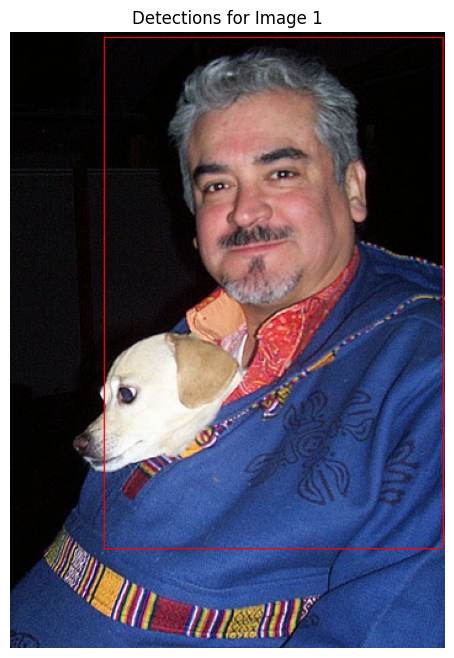

Image 2:
Inference time: 0.2275 seconds
Number of detections: 4
High confidence detections:
  Class: person, Score: 0.8299, Box: [33.16675567626953, 0.0, 352.4520568847656, 375.0]


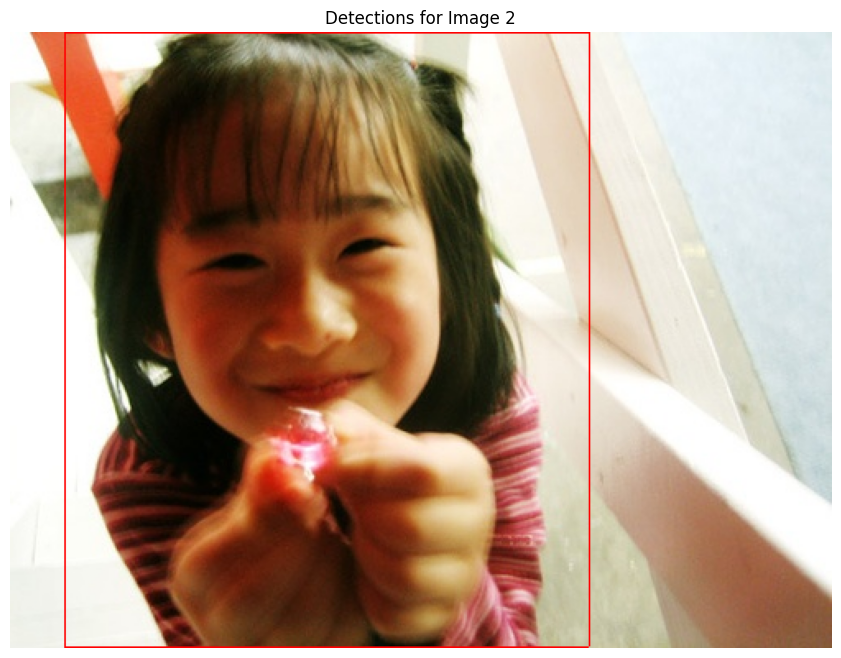

Image 3:
Inference time: 0.2968 seconds
Number of detections: 31
High confidence detections:
  Class: person, Score: 0.6569, Box: [316.94281005859375, 135.92584228515625, 368.06365966796875, 191.14138793945312]
  Class: person-like, Score: 0.6544, Box: [104.48529052734375, 156.25363159179688, 150.25881958007812, 298.5851745605469]
  Class: person-like, Score: 0.6298, Box: [217.6809844970703, 145.0307159423828, 270.25970458984375, 287.6827392578125]
  Class: person-like, Score: 0.6138, Box: [61.403350830078125, 138.0155487060547, 114.03376770019531, 311.6996765136719]
  Class: person-like, Score: 0.6113, Box: [11.746034622192383, 144.18182373046875, 51.71831512451172, 292.9997863769531]
  Class: person-like, Score: 0.5794, Box: [258.9536437988281, 142.627197265625, 290.46026611328125, 270.6684265136719]
  Class: person, Score: 0.5601, Box: [264.3518981933594, 127.57481384277344, 323.1558837890625, 275.5594787597656]
  Class: person-like, Score: 0.5584, Box: [262.4103698730469, 138.53096

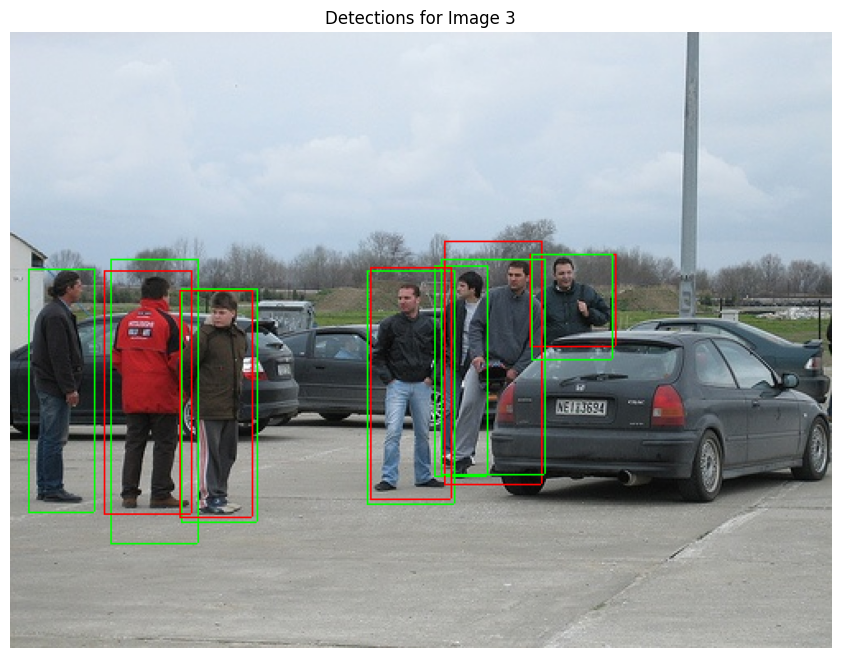

Image 4:
Inference time: 0.2257 seconds
Number of detections: 8
High confidence detections:
  Class: person, Score: 0.7399, Box: [142.69606018066406, 32.689598083496094, 340.239013671875, 325.2669372558594]


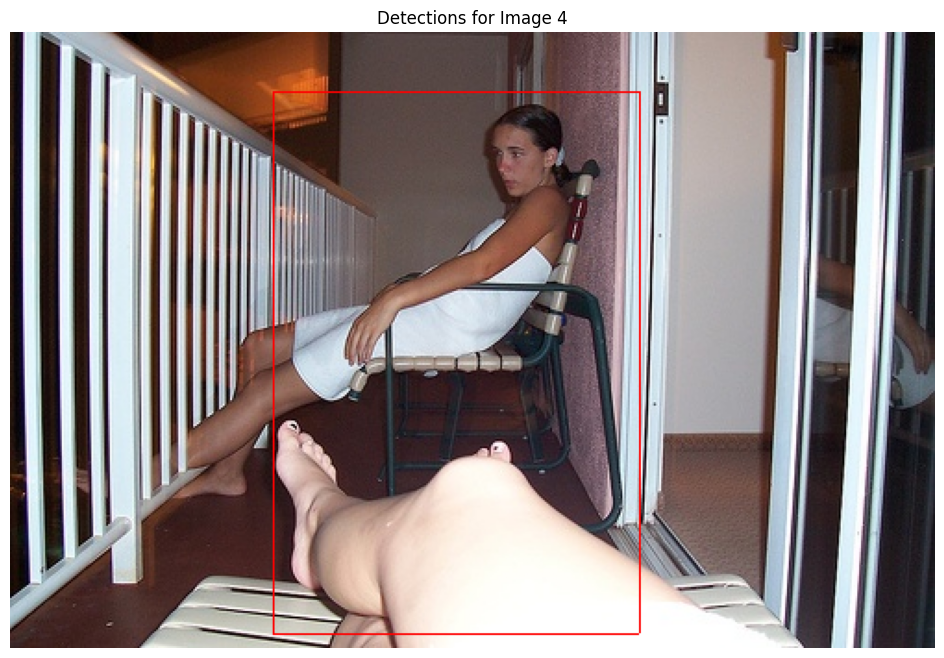

Image 5:
Inference time: 0.2177 seconds
Number of detections: 7
High confidence detections:
  Class: person-like, Score: 0.8374, Box: [275.0545349121094, 71.6260986328125, 341.2808532714844, 263.3876037597656]
  Class: person-like, Score: 0.7617, Box: [378.92535400390625, 170.5756072998047, 462.110107421875, 278.39959716796875]


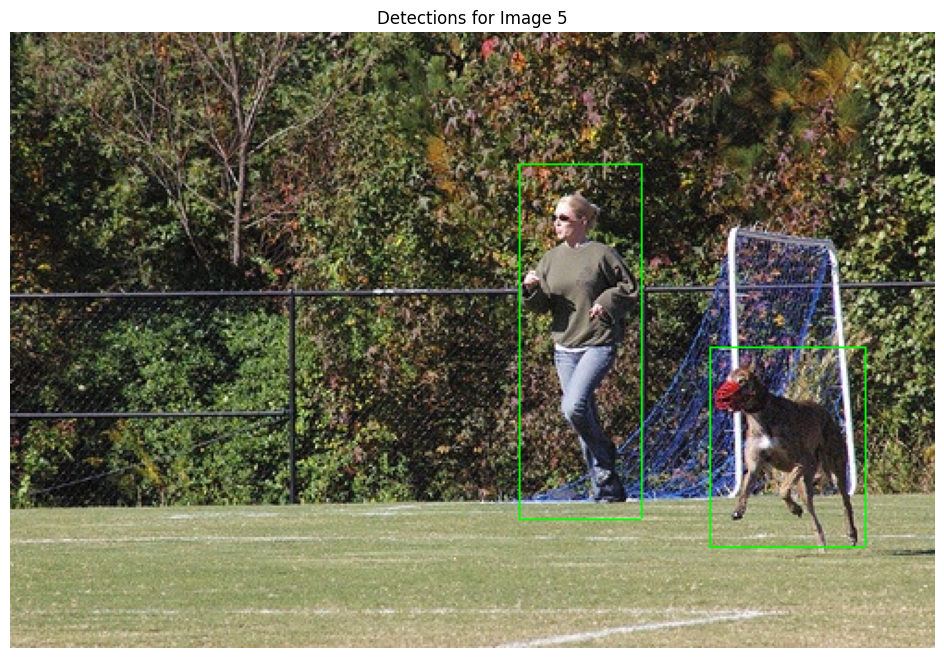

In [7]:
# Evaluate the model
def collate_fn(batch):
    return tuple(zip(*batch))


test_dataset = CustomDataset("/teamspace/studios/this_studio/dataset_f_r_cnn/Test/Test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=8, pin_memory=True)


CLASS_NAMES = {
    0: 'background',
    1: 'person',
    2: 'person-like'
}

def evaluate_with_debug(model, data_loader, device):
    model.eval()

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = list(img.to(device) for img in images)

            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time

            print(f"Image {i+1}:")
            print(f"Inference time: {inference_time:.4f} seconds")
            print(f"Number of detections: {len(outputs[0]['boxes'])}")

            # Visualizing results 
            img = images[0].cpu()
            output = outputs[0]

            # Getting predictions with high confidence
            keep = output['scores'] > 0.5
            boxes = output['boxes'][keep]
            labels = output['labels'][keep]
            scores = output['scores'][keep]

            print("High confidence detections:")
            for box, label, score in zip(boxes, labels, scores):
                class_name = CLASS_NAMES[label.item()]
                print(f"  Class: {class_name}, Score: {score.item():.4f}, Box: {box.tolist()}")

            try:
                # Drawing bounding boxes
                img_with_boxes = draw_boxes(img, boxes, labels)

                plt.figure(figsize=(12, 8))
                plt.imshow(img_with_boxes.permute(1, 2, 0))
                plt.axis('off')
                plt.title(f"Detections for Image {i+1}")
                plt.show()
            except Exception as e:
                print(f"Error drawing boxes for image {i+1}: {str(e)}")

            if i == 4:  # Showing only 5 images for demonstration
                break

# Define the model architecture
model = get_model(num_classes=3)  # 3 classes: background, person, person-like

# Load the best model
model.load_state_dict(torch.load('best_model_resnet50.pth'))

# Move the model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Evaluating the best model...")
evaluate_with_debug(model, test_loader, device)

In [8]:
def calculate_metrics(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5, nms_threshold=0.5):
    model.eval()
    all_detections = []
    all_ground_truths = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                detections = {
                    'boxes': output['boxes'].cpu(),
                    'scores': output['scores'].cpu(),
                    'labels': output['labels'].cpu()
                }
                all_detections.append(detections)
                all_ground_truths.append({k: v.cpu() for k, v in target.items()})

    precision = defaultdict(list)
    recall = defaultdict(list)
    ap_per_class = defaultdict(list)

    for detections, ground_truths in zip(all_detections, all_ground_truths):
        for class_id in torch.unique(ground_truths['labels']):
            if class_id == 0:
                continue  # Skiping background class

            true_positives = torch.zeros(len(detections['boxes']))
            false_positives = torch.zeros(len(detections['boxes']))

            gt_masks = ground_truths['labels'] == class_id
            gt_boxes = ground_truths['boxes'][gt_masks]

            if len(gt_boxes) == 0:
                continue

            det_masks = detections['labels'] == class_id
            det_boxes = detections['boxes'][det_masks]
            det_scores = detections['scores'][det_masks]

            if len(det_boxes) == 0:
                false_positives = torch.ones(len(gt_boxes))
            else:
                ious = box_iou(det_boxes, gt_boxes)
                max_ious, max_indices = ious.max(dim=1)

                detected_gt = set()
                for i, (iou, idx) in enumerate(zip(max_ious, max_indices)):
                    if iou >= iou_threshold and idx.item() not in detected_gt:
                        true_positives[i] = 1
                        detected_gt.add(idx.item())
                    else:
                        false_positives[i] = 1

            # Applying NMS
            keep = nms(det_boxes, det_scores, iou_threshold=nms_threshold)
            det_boxes = det_boxes[keep]
            det_scores = det_scores[keep]

            sorted_indices = torch.argsort(det_scores, descending=True)
            true_positives = true_positives[sorted_indices]
            false_positives = false_positives[sorted_indices]

            cum_true_positives = torch.cumsum(true_positives, dim=0)
            cum_false_positives = torch.cumsum(false_positives, dim=0)

            precision_val = cum_true_positives / (cum_true_positives + cum_false_positives + 1e-10)
            recall_val = cum_true_positives / len(gt_boxes)

            precision[class_id.item()].append(precision_val[-1].item())
            recall[class_id.item()].append(recall_val[-1].item())

            ap = torch.trapz(precision_val, recall_val)
            ap_per_class[class_id.item()].append(ap.item())

    avg_precision = {k: sum(v) / len(v) for k, v in precision.items()}
    avg_recall = {k: min(sum(v) / len(v), 1.0) for k, v in recall.items()}  # Ensure recall is capped at 1.0
    avg_ap = {k: sum(v) / len(v) for k, v in ap_per_class.items()}
    mAP = sum(avg_ap.values()) / len(avg_ap)

    return avg_precision, avg_recall, avg_ap, mAP

# Loading model and adjust parameters as needed
precision, recall, ap, mAP = calculate_metrics(model, test_loader, device, iou_threshold=0.7, nms_threshold=0.5)

# Printing results
print(f"Model summary: {sum(p.numel() for p in model.parameters())} parameters, 0 gradients")
print(f"{'Class':>20} {'Images':>10} {'Instances':>10} {'P':>10} {'R':>10} {'mAP50':>10}")

all_instances = sum(len(t['boxes']) for _, t in test_loader.dataset)
print(f"{'all':>20} {len(test_loader.dataset):>10} {all_instances:>10} "
      f"{sum(precision.values())/len(precision):>10.3f} {sum(recall.values())/len(recall):>10.3f} {mAP:>10.3f}")

for cls, name in CLASS_NAMES.items():
    if cls == 0:
        continue  # Skiping background
    num_instances = sum(t['labels'].eq(cls).sum().item() for _, t in test_loader.dataset)
    print(f"{name:>20} {len(test_loader.dataset):>10} {num_instances:>10} "
          f"{precision[cls]:>10.3f} {recall[cls]:>10.3f} {ap[cls]:>10.3f}")


Model summary: 41304286 parameters, 0 gradients
               Class     Images  Instances          P          R      mAP50
                 all        235        595      0.258      0.835      0.221
              person        235        317      0.236      0.804      0.155
         person-like        235        278      0.280      0.866      0.288


### Confusion Matrix

Getting predictions...


Computing confusion matrix...
Plotting confusion matrix...


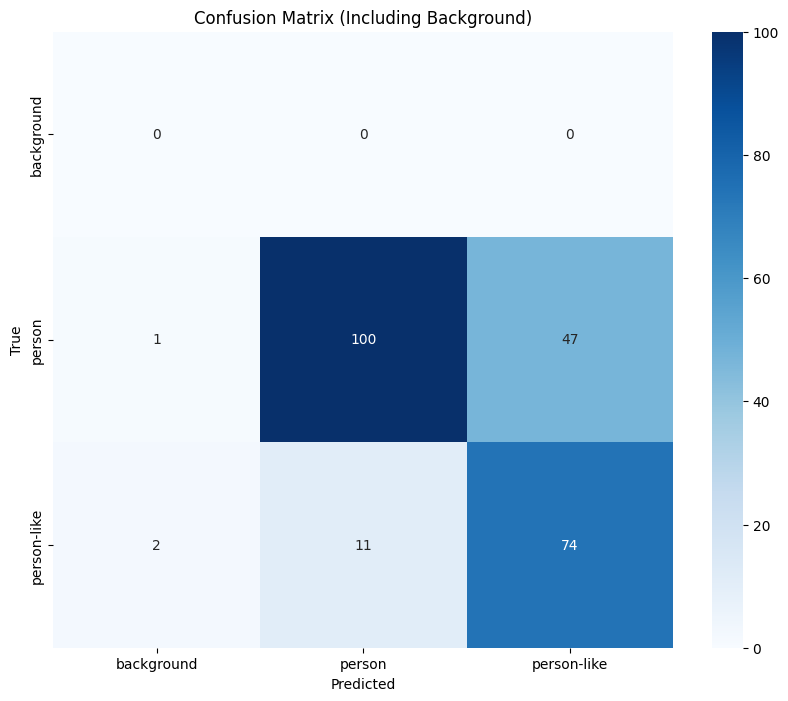

Done!


In [19]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the collate_fn function
def collate_fn(batch):
    return tuple(zip(*batch))

# Define the function to get predictions
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_labels = output['labels'][output['scores'] > 0.5].cpu().numpy()
                target_labels = target['labels'].cpu().numpy()
                
                # For each image, we'll consider the most common prediction and target
                if len(pred_labels) > 0:
                    pred = np.bincount(pred_labels).argmax()
                else:
                    pred = 0  # Background if no predictions
                
                if len(target_labels) > 0:
                    true = np.bincount(target_labels).argmax()
                else:
                    true = 0  # Background if no targets
                
                all_preds.append(pred)
                all_targets.append(true)
    
    return np.array(all_preds), np.array(all_targets)

# function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Including Background)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


test_dataset = CustomDataset("/teamspace/studios/this_studio/dataset_f_r_cnn/Test/Test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=8, pin_memory=True)


CLASS_NAMES = {
    0: 'background',
    1: 'person',
    2: 'person-like'
}

# trained model
model = get_model(num_classes=3)
model.load_state_dict(torch.load('best_model_resnet50.pth'))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Geting predictions
print("Getting predictions...")
y_pred, y_true = get_predictions(model, test_loader, device)

# Computing confusion matrix
print("Computing confusion matrix...")
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

# Plotting confusion matrix
print("Plotting confusion matrix...")
plot_confusion_matrix(cm, list(CLASS_NAMES.values()))

print("Done!")


## Curves

Class background: 0 predictions, 595 targets
No predictions for class background
Class person: 2067 predictions, 595 targets
Class person-like: 1930 predictions, 595 targets


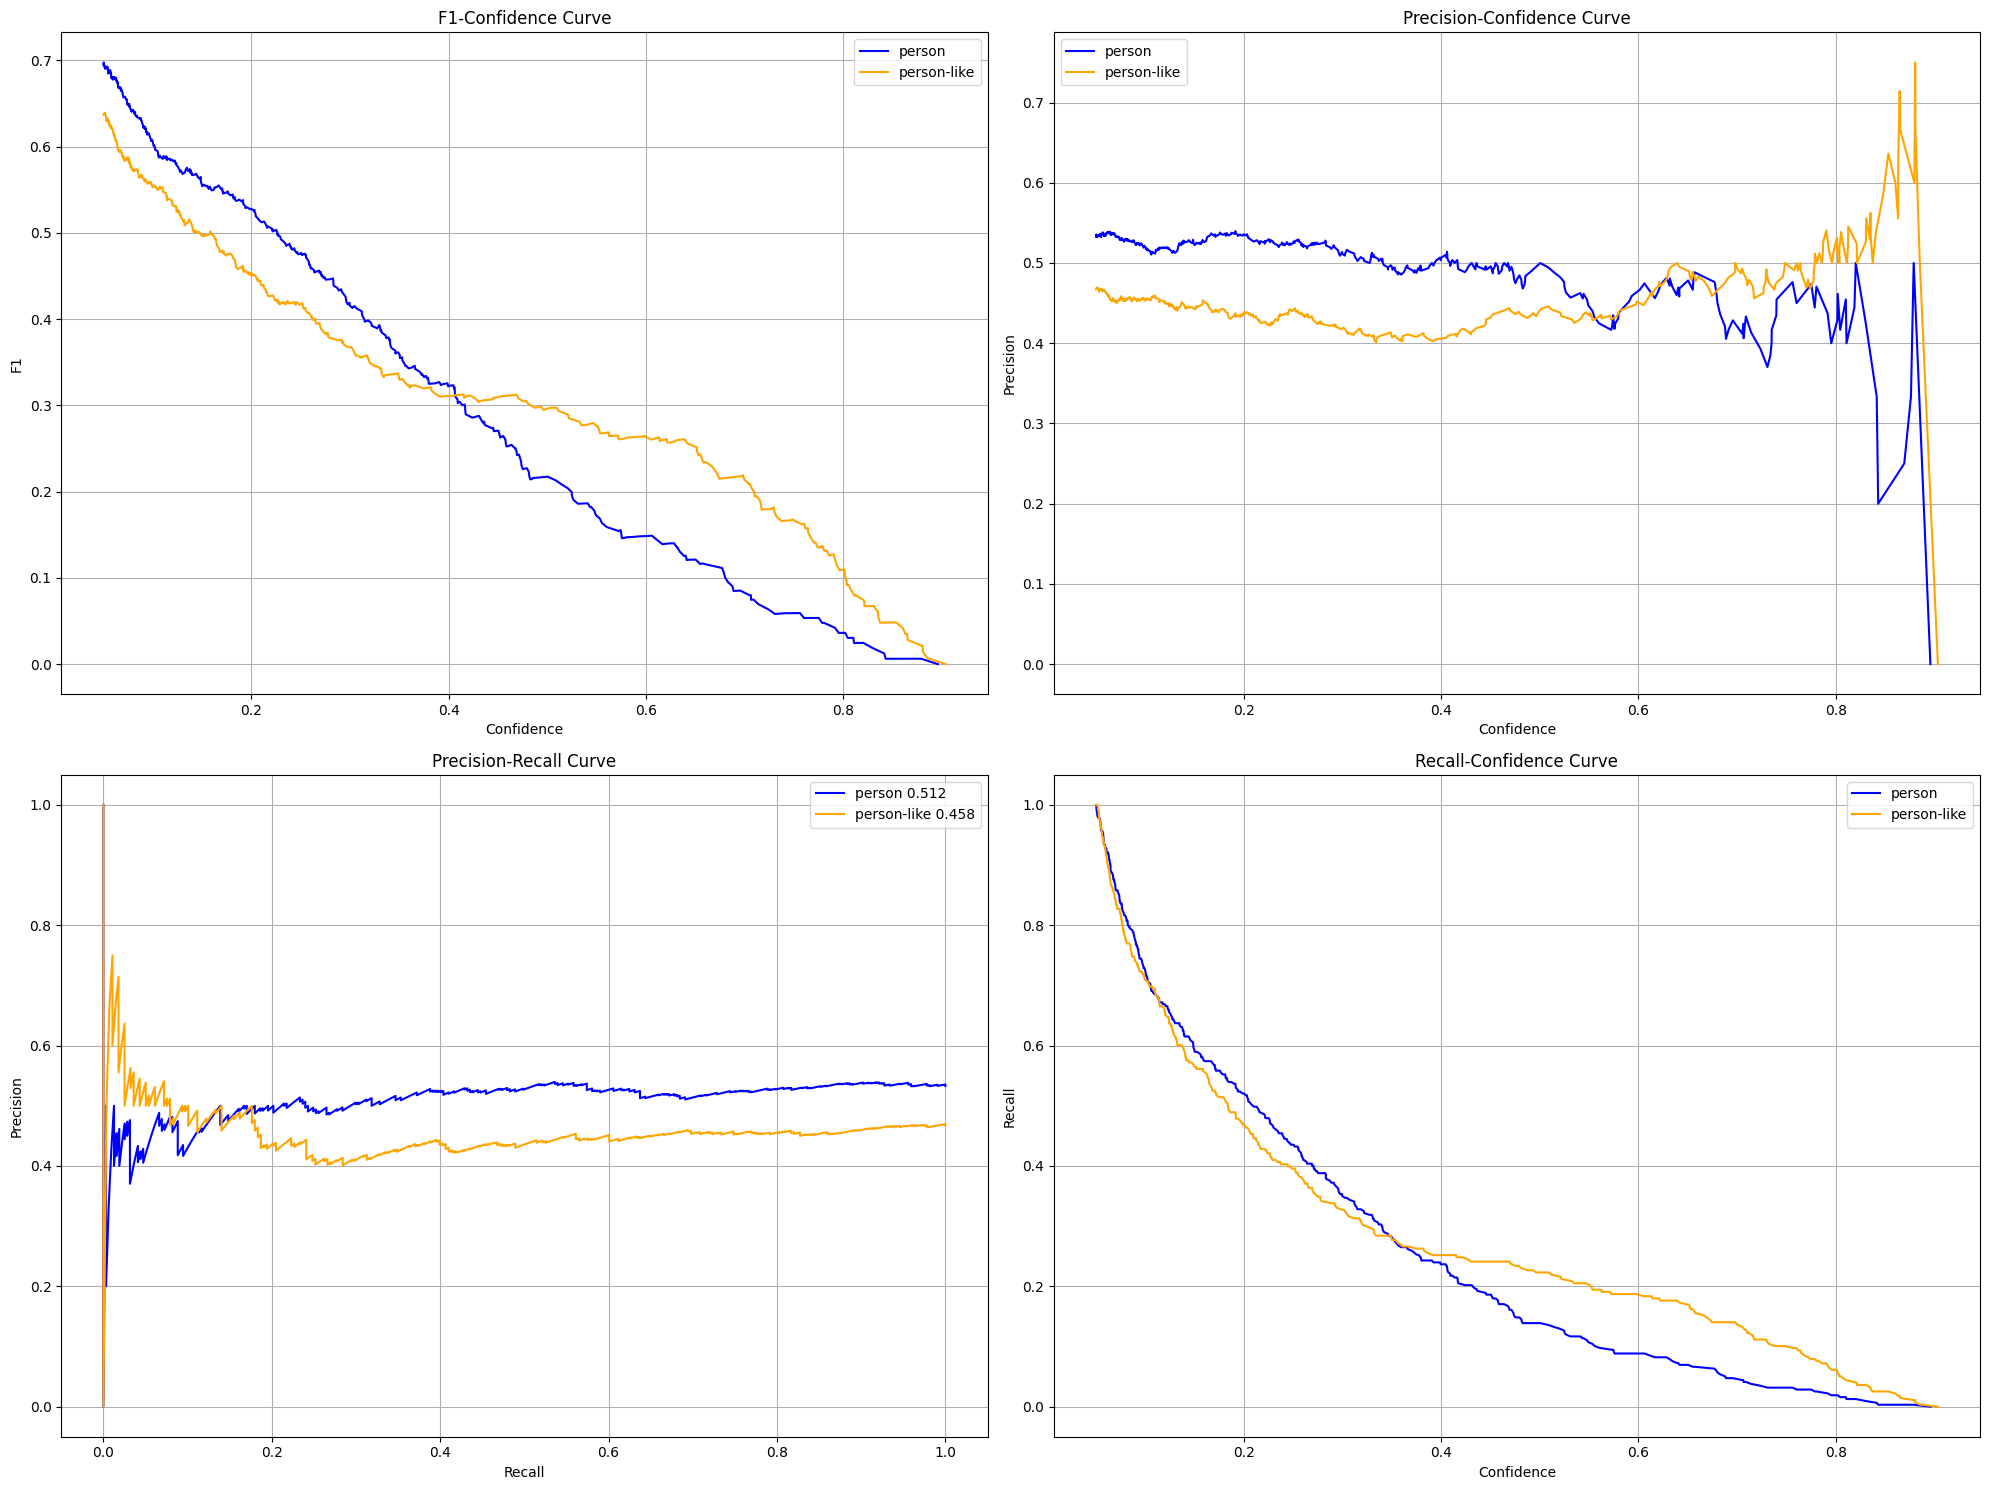

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch
from torch.utils.data import DataLoader

# Loading the model
def load_model(model_path, model):
    model.load_state_dict(torch.load(model_path))
    return model

#  evaluate the model and get predictions and targets
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                
                target_labels = target['labels'].cpu().numpy()
                
                all_predictions.extend([(l, s) for l, s in zip(labels, scores)])
                all_targets.extend(target_labels)
    
    return all_predictions, all_targets

# plot of the precision-recall and related curves
def plot_curves(all_predictions, all_targets):
    class_names = ['background', 'person', 'person-like']
    colors = ['green', 'blue', 'orange']
    
    plt.figure(figsize=(20, 15))
    
    for i, class_name in enumerate(class_names):
        class_preds = [s for l, s in all_predictions if l == i]
        class_targets = [1 if t == i else 0 for t in all_targets]
        
        # Debugging prints
        print(f"Class {class_name}: {len(class_preds)} predictions, {len(class_targets)} targets")

        if len(class_preds) == 0:
            print(f"No predictions for class {class_name}")
            continue
        
        if len(class_targets) == 0:
            print(f"No targets for class {class_name}")
            continue
        
        # we Align lengths of class_preds and class_targets
        min_length = min(len(class_preds), len(class_targets))
        class_preds = class_preds[:min_length]
        class_targets = class_targets[:min_length]
        
        precisions, recalls, thresholds = precision_recall_curve(class_targets, class_preds)
        
        # F1-Confidence Curve
        plt.subplot(2, 2, 1)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        plt.plot(thresholds, f1_scores[:-1], color=colors[i], label=class_name)
        
        # Precision-Confidence Curve
        plt.subplot(2, 2, 2)
        plt.plot(thresholds, precisions[:-1], color=colors[i], label=class_name)
        
        # Precision-Recall Curve
        plt.subplot(2, 2, 3)
        ap = average_precision_score(class_targets, class_preds)
        plt.plot(recalls, precisions, color=colors[i], label=f'{class_name} {ap:.3f}')
        
        # Recall-Confidence Curve
        plt.subplot(2, 2, 4)
        plt.plot(thresholds, recalls[:-1], color=colors[i], label=class_name)
    
    # Finalize plots
    titles = ['F1-Confidence Curve', 'Precision-Confidence Curve', 
              'Precision-Recall Curve', 'Recall-Confidence Curve']
    
    for i, title in enumerate(titles):
        plt.subplot(2, 2, i+1)
        plt.title(title)
        plt.xlabel('Confidence' if 'Confidence' in title else 'Recall')
        plt.ylabel('F1' if 'F1' in title else ('Precision' if 'Precision' in title else 'Recall'))
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Loading the best model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = load_model('best_model_resnet50.pth', model)
model.to(device)

all_predictions, all_targets = evaluate_model(model, test_loader, device)
plot_curves(all_predictions, all_targets)


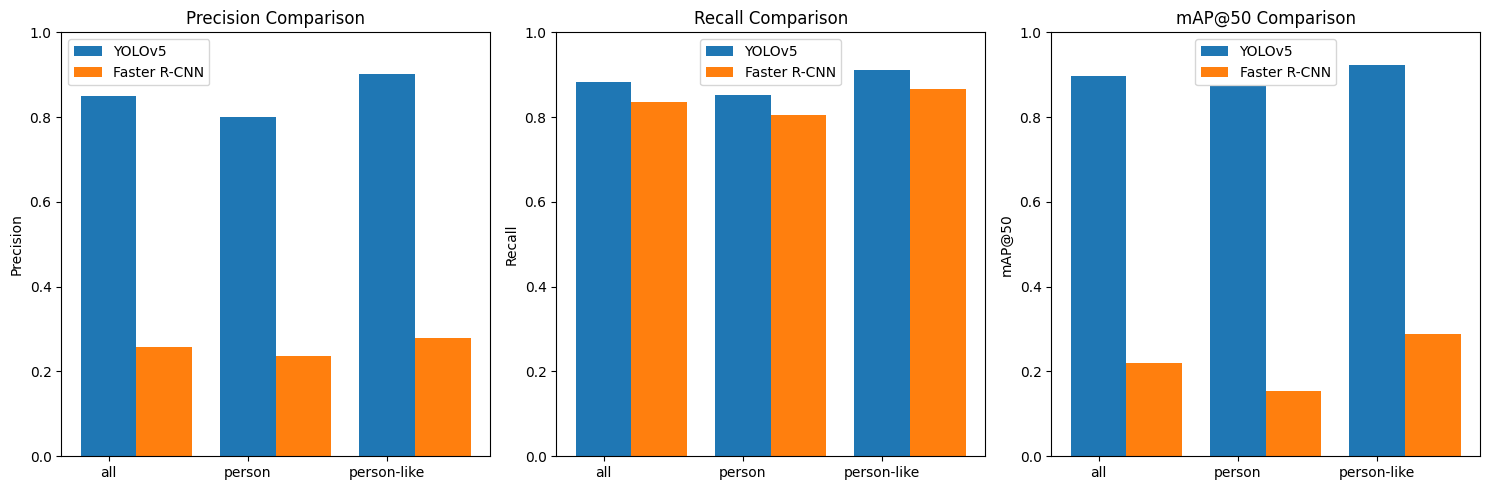

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for YOLOv5
metrics_yolov5 = {
    'Class': ['all', 'person', 'person-like'],
    'Precision': [0.851, 0.801, 0.901],
    'Recall': [0.882, 0.853, 0.911],
    'mAP@50': [0.898, 0.874, 0.922]
}

# Metrics for Faster R-CNN with ResNet50
metrics_faster_rcnn = {
    'Class': ['all', 'person', 'person-like'],
    'Precision': [0.258, 0.236, 0.280],
    'Recall': [0.835, 0.804, 0.866],
    'mAP@50': [0.221, 0.155, 0.288]
}

# Extract metrics for plotting
classes = metrics_yolov5['Class']
precision_yolov5 = metrics_yolov5['Precision']
precision_faster_rcnn = metrics_faster_rcnn['Precision']
recall_yolov5 = metrics_yolov5['Recall']
recall_faster_rcnn = metrics_faster_rcnn['Recall']
mAP_yolov5 = metrics_yolov5['mAP@50']
mAP_faster_rcnn = metrics_faster_rcnn['mAP@50']

# Plotting the metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Precision comparison
ax1.bar(classes, precision_yolov5, width=0.4, label='YOLOv5')
ax1.bar(np.arange(len(classes)) + 0.4, precision_faster_rcnn, width=0.4, label='Faster R-CNN')
ax1.set_title('Precision Comparison')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Precision')
ax1.legend()

# Recall comparison
ax2.bar(classes, recall_yolov5, width=0.4, label='YOLOv5')
ax2.bar(np.arange(len(classes)) + 0.4, recall_faster_rcnn, width=0.4, label='Faster R-CNN')
ax2.set_title('Recall Comparison')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Recall')
ax2.legend()

# mAP@50 comparison
ax3.bar(classes, mAP_yolov5, width=0.4, label='YOLOv5')
ax3.bar(np.arange(len(classes)) + 0.4, mAP_faster_rcnn, width=0.4, label='Faster R-CNN')
ax3.set_title('mAP@50 Comparison')
ax3.set_ylim(0, 1)
ax3.set_ylabel('mAP@50')
ax3.legend()

# Adjustting layout
plt.tight_layout()

# Showing plot
plt.show()
